# Score plots

In [1]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts, dWs
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean
from jaxgeometry.stochastics import Brownian_coords, product_sde, Brownian_sR
from jaxgeometry.stochastics.product_sde import tile
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

#from ManLearn.VAE.VAE_MNIST import model as mnist_model
#from ManLearn.VAE.VAE_MNIST import model_encoder as mnist_encoder
#from ManLearn.VAE.VAE_MNIST import model_decoder as mnist_decoder
#from ManLearn.VAE.VAE_MNIST import VAEOutput as mnist_output

#from ManLearn.VAE.VAE_SVHN import model as svhn_model
#from ManLearn.VAE.VAE_SVHN import model_encoder as svhn_encoder
#from ManLearn.VAE.VAE_SVHN import model_decoder as svhn_decoder
#from ManLearn.VAE.VAE_SVHN import VAEOutput as svhn_output

#from ManLearn.VAE.VAE_CelebA import model as celeba_model
#from ManLearn.VAE.VAE_CelebA import model_encoder as celeba_encoder
#from ManLearn.VAE.VAE_CelebA import model_decoder as celeba_decoder
#from ManLearn.VAE.VAE_CelebA import VAEOutput as celeba_output

#from ManLearn.train_MNIST import load_dataset as load_mnist
#from ManLearn.train_SVHN import load_dataset as load_svhn
#from ManLearn.train_CelebA import load_dataset as load_celeba
#from ManLearn.model_loader import load_model

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

2023-12-19 02:04:29.289407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Define Manifolds

In [3]:
loss_type = 'dsm'

In [4]:
T = 0.5

In [5]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

In [6]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

### $\mathbb{R}^{2}$

In [7]:
R2 = Euclidean(N=2)
jstoch.Brownian_coords(R2)
jstat.diffusion_mean(R2)
R2_x0 = (jnp.zeros(2), jnp.zeros(1))

using M.Exp for Logarithm


In [8]:
file_path = 'scores/R2/s1_'+ loss_type + '/'
r2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_r2 = hk.transform(lambda x: models.MLP_s1(dim=R2.dim, layers=layers)(x))
s2_r2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R2.dim, r = max(R3.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_r2(x,y,t):
    
    return s1_r2.apply(r2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_r2(x,y,t):
    
    grad_val = grady_log_r2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_r2(x, y, t)))

def ggrady_log_r2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_r2.apply(r2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [9]:
N_points = 1000
min_x = -2.0
max_x = 2.0
x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_R2, X2_R2 = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_R2.reshape(1, N_points, N_points), 
                     X2_R2.reshape(1, N_points, N_points))), axes=(1,2,0))

theoretical_grad = lambda y: R2.grady_log_hk(R2_x0, (y, jnp.zeros(1)), T)[0]
numerical_grad = lambda y: grady_log_r2(R2_x0, (y, jnp.zeros(1)), T)
R2_grad = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(X_heat)
R2_angle = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)
R2_l2 = vmap(lambda x2: \
                vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

### $\mathbb{R}^{3}$

In [30]:
R3 = Euclidean(N=3)
jstoch.Brownian_coords(R3)
jstat.diffusion_mean(R3)
R3_x0 = (jnp.zeros(3), jnp.zeros(1))

using M.Exp for Logarithm


In [31]:
file_path = 'scores/R3/'+ loss_type + '/'
r3_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_r3 = hk.transform(lambda x: models.MLP_s1(dim=R3.dim, layers=layers)(x))
s2_r3 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R3.dim, r = max(R3.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_r3(x,y,t):
    
    return s1_r3.apply(r3_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_r3(x,y,t):
    
    grad_val = grady_log_r3(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_r3(x, y, t)))

def ggrady_log_r3(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_r3.apply(r3_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [32]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
# Creating the theta and phi values
N_points = 100

min_x = -2.0
max_x = 2.0

x1 = jnp.linspace(min_x, max_x, N_points)
x2 = jnp.linspace(min_x, max_x, N_points)
x3 = jnp.linspace(min_x, max_x, N_points)

# Creating the coordinate grid for the unit sphere.
X1_r3, X2_r3, X3_r3 = jnp.meshgrid(x1, x2, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_r3.reshape(1, N_points,N_points, N_points), 
                     X2_r3.reshape(1, N_points,N_points, N_points),
                                       X3_r3.reshape(1, N_points,N_points, N_points))), axes=(1,2,3,0))

theoretical_grad = lambda y: R3.grady_log_hk(R3_x0, (y, jnp.zeros(1)), T)[0]
numerical_grad = lambda y: grady_log_r3(R3_x0, (y, jnp.zeros(1)), T)
R3_grad = vmap(lambda x3: vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(x3))(X_heat)
R3_angle = vmap(lambda x3: vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(x3))(X_heat)
R3_l2 = vmap(lambda x3: \
                vmap(lambda x2: \
                     vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(x3))(X_heat)


### $\mathbb{S}^{1}$

In [33]:
S1M = S1(use_spherical_coords=True)
jstoch.Brownian_coords(S1M)
jstat.diffusion_mean(S1M)
S1M_x0 = S1M.coords([0.])

using M.Exp for Logarithm


In [34]:
file_path = 'scores/S1/'+ loss_type + '/'
s1_state = model_loader.load_model(file_path)
layers = [50, 100, 50]
s1_s1 = hk.transform(lambda x: models.MLP_s1(dim=S1M.dim, layers=layers)(x))
s2_s1 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S1M.dim, r = max(S1M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s1(x,y,t):
    
    return s1_s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_s1(x,y,t):
    
    grad_val = grady_log_s1(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s1(x, y, t)))

def ggrady_log_s1(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [35]:
# Creating the theta and phi values.
N_points = 1000
phi_heat   = jnp.linspace(0.0, jnp.pi*2, N_points)

# Creating the coordinate grid for the unit sphere.
X1_s1 = jnp.cos(phi_heat)
X2_s1 = jnp.sin(phi_heat)
X_s1 = jnp.transpose(jnp.concatenate((X1_s1.reshape(1, N_points), 
                     X2_s1.reshape(1, N_points))))

theoretical_grad = lambda y: S1M.grady_log_hk(S1M_x0, get_coords(S1M, y), T)
numerical_grad = lambda y: grady_log_s1(S1M_x0, get_coords(S1M, y), T)
S1_grad = vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(X_s1)
S1_angle = vmap(lambda x1: angle_between(theoretical_grad(x1),numerical_grad(x1)))(X_s1)
S1_l2 = vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(X_s1)

### $\mathbb{S}^{2}$

In [10]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [11]:
file_path = 'scores/S2/s1_'+ loss_type + '/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s2(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_s2(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log_s2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [12]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

theoretical_grad = lambda y: S2.grady_log_hk(S2_x0, get_coords(S2,y), T)[0]
numerical_grad = lambda y: grady_log_s2(S2_x0, get_coords(S2,y), T)
S2_grad = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(numerical_grad(x1)))(x2))(X_heat)
S2_angle = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)
S2_l2 = vmap(lambda x2: \
                vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

### Landmarks 2D

In [39]:
L2 = Landmarks(N=2, m=2)
jstoch.Brownian_coords(L2)
jstat.diffusion_mean(L2)
L2_x0 = L2.coords(jnp.vstack((jnp.linspace(-5.0,5.0,L2.N),jnp.zeros(L2.N))).T.flatten())

using M.Exp for Logarithm


In [40]:
file_path = 'scores/Landmarks2/'+ loss_type + '/'
l2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_l2 = hk.transform(lambda x: models.MLP_s1(dim=L2.dim, layers=layers)(x))
s2_l2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=L2.dim, r = max(L2.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_l2(x,y,t):
    
    return s1_l2.apply(l2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_l2(x,y,t):
    
    grad_val = grady_log_l2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_l2(x, y, t)))

def ggrady_log_l2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_l2.apply(l2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### SPDN 2D

In [41]:
SPDN2 = SPDN(N=2)
jstoch.Brownian_coords(SPDN2)
jstat.diffusion_mean(SPDN2)
SPDN2_x0 = SPDN2.coords([0.]*(2*(2+1)//2))

using M.Exp for Logarithm


In [42]:
file_path = 'scores/SPDN2/'+ loss_type + '/'
spdn2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_spdn2 = hk.transform(lambda x: models.MLP_s1(dim=SPDN2.dim, layers=layers)(x))
s2_spdn2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=SPDN2.dim, r = max(SPDN2.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_spdn2(x,y,t):
    
    return s1_spdn2.apply(spdn2_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_spdn2(x,y,t):
    
    grad_val = grady_log_spdn2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_spdn2(x, y, t)))

def ggrady_log_spdn2(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1_spdn2.apply(spdn2_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

### Cylinder

In [43]:
T2 = Torus()
jstoch.Brownian_coords(T2)
jstat.diffusion_mean(T2)
x0 = T2.coords([0.]*2)

using M.Exp for Logarithm


In [44]:
file_path = 'scores/Torus/'+ loss_type + '/'
t2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_t2 = hk.transform(lambda x: models.MLP_s1(dim=T2.dim, layers=layers)(x))
s2_t2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=T2.dim, r = max(T2.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_t2(x,y,t):
    
    return to_TMx(T2, y[1], s1_t2.apply(t2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_t2(x,y,t):
    
    grad_val = grady_log_t2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_t2(x, y, t)))

def ggrady_log_t2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(T2, y[1], s1_t2.apply(t2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

## Comparison to Analytical Gradients

### Comparison of Angle

NameError: name 'X_s1' is not defined

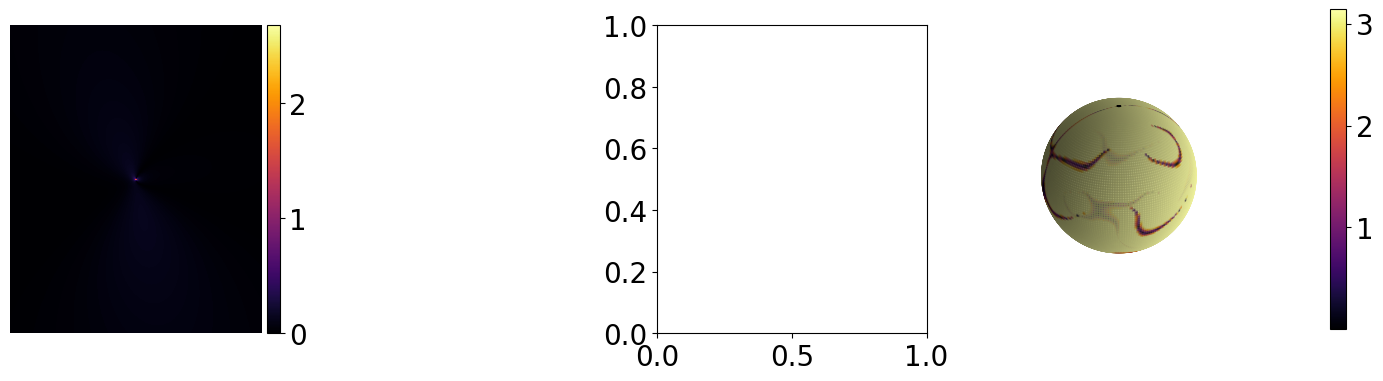

In [13]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_angle, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_angle)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_angle*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_angle)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_angle, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_angle)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,:,0]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,:,-1]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,0,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[:,-1,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[0,:,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_angle[-1,:,:]*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R3_angle)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_angle.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


### Comparison of L2-Norm

NameError: name 'X_s1' is not defined

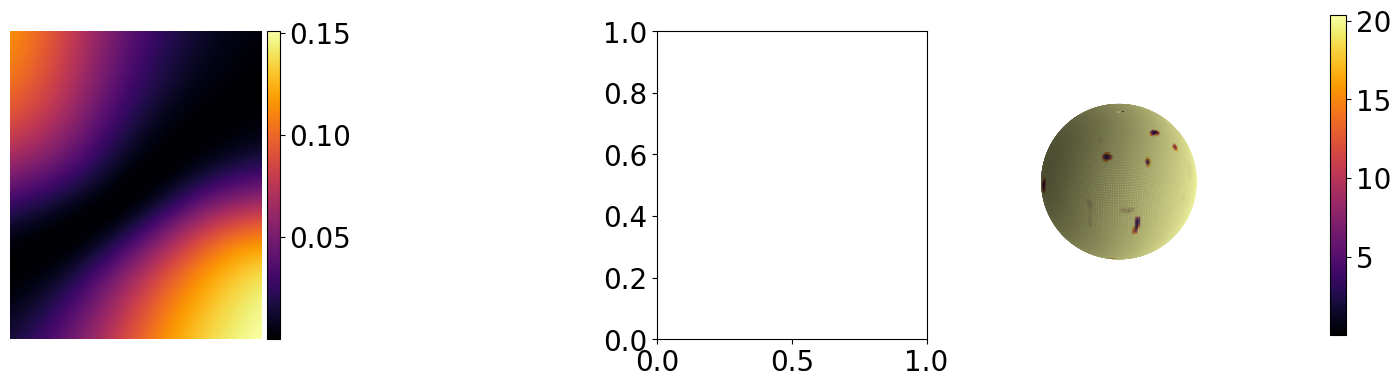

In [15]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_l2, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_l2)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_l2*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_l2)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_l2, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_l2)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,:,0]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,:,-1]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,0,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[:,-1,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[0,:,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_l2[-1,:,:]*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
heat_map = jnp.stack((R3_l2[:,:,0],
                     R3_l2[:,:,-1],
                     R3_l2[:,0,:],
                     R3_l2[:,-1,:],
                     R3_l2[0,:,:],
                     R3_l2[-1,:,:]))
m.set_array(heat_map)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_l2.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


### Plotting Learned Gradient

/tmp/ipykernel_9688/3070281825.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


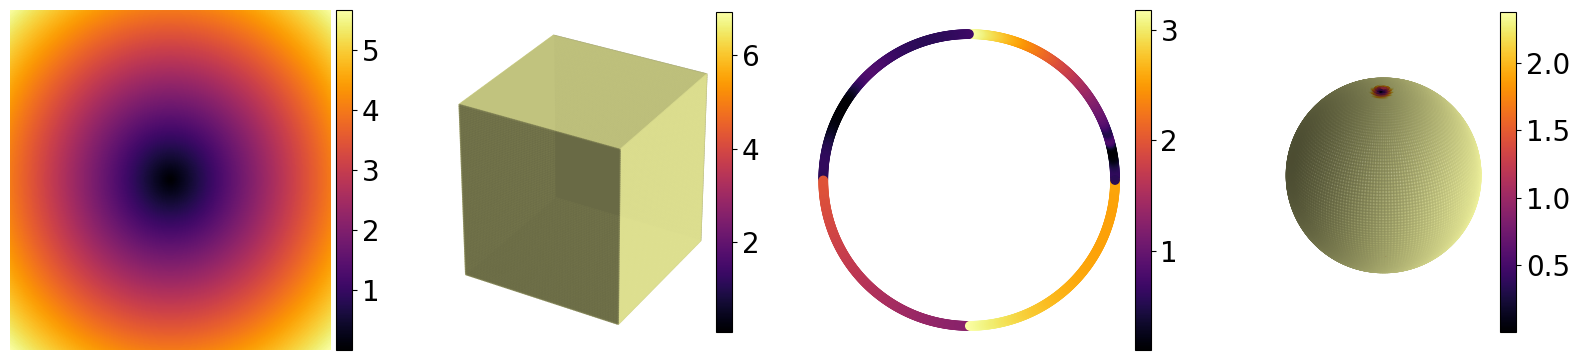

In [50]:
fig = plt.figure(figsize=(16,4))

#R2
ax = fig.add_subplot(1,4,1)
ax.imshow(R2_grad, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R2_grad)
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#S1
ax = fig.add_subplot(1,4,3)
ax.scatter(X_s1[:,0], X_s1[:,1], c=S1_grad, cmap=plt.cm.inferno)
ax.set_ylim((-1.1,1.1))
ax.set_xlim((-1.1,1.1))
ax.autoscale(False)
ax.set_box_aspect(1.0)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S1_grad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

#R3
ax = fig.add_subplot(1,4,2, projection='3d')
ax.plot_surface(X1_r3[:,:,0], X2_r3[:,:,0], X3_r3[:,:,0], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,:,0]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,:,-1], X2_r3[:,:,-1], X3_r3[:,:,-1], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,:,-1]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,0,:], X2_r3[:,0,:], X3_r3[:,0,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,0,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[:,-1,:], X2_r3[:,-1,:], X3_r3[:,-1,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[:,-1,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[0,:,:], X2_r3[0,:,:], X3_r3[0,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[0,:,:]*10), alpha=0.5)
ax.plot_surface(X1_r3[-1,:,:], X2_r3[-1,:,:], X3_r3[-1,:,:], rstride=1, cstride=1, facecolors=plt.cm.inferno(R3_grad[-1,:,:]*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(R3_grad)
divider = make_axes_locatable(ax)
cax = plt.axes([0.46, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

#S2
ax = fig.add_subplot(1,4,4, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, facecolors=plt.cm.inferno(S2_grad*10), alpha=0.5)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(S2_grad)
divider = make_axes_locatable(ax)
cax = plt.axes([0.95, 0.12, 0.01, 0.80])
fig.colorbar(m, cax=cax, format=cbformat)#, cax=cax)

fig.tight_layout()

plt.show()

fig.savefig('Figures/comparison_grad.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Synthetic Data Plot

In [51]:
M = nSphere(N=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [52]:
file_path = 'scores/S2/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Estimating Diffusion t-Mean

In [53]:
xs = pd.read_csv('Data/S2/xs.csv', header=None)
charts = pd.read_csv('Data/S2/chart.csv', header=None)
X_sphere = (jnp.array(xs.values), jnp.array(charts.values))

In [54]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [55]:
musphere_sm, Tsphere_sm, _, _ = M.sm_dmxt(X_sphere, (X_sphere[0][0], X_sphere[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [56]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_sphere,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_sphere,num_steps=100, N=1)

musphere_bridgex, Tsphere_bridge, musphere_bridgechart = zip(*mu_bridge)
musphere_bridgex, musphere_bridghechart = jnp.stack(musphere_bridgex), jnp.stack(musphere_bridgechart)
Tsphere_bridge = jnp.stack(Tsphere_bridge)

Step 0 | T: 9.626102e+00 | T: ((Array([-0.08633253, -0.04858186], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 8.433688e+00 | T: ((Array([-0.07642116, -0.03870183], dtype=float32), Array(0.21992095, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Final 1 | T: 8.433688e+00 | T: (Array([-0.07642116, -0.03870183], dtype=float32), Array(0.21992095, dtype=float32))
Step 0 | T: 9.625757e+00 | T: ((Array([-0.08633253, -0.04858186], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 8.432480e+00 | T: ((Array([-0.07642168, -0.03870153], dtype=float32), Array(0.21992089, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.434329e+00 | T: ((Array([-0.06665912, -0.02902951], dtype=float32), Array(0.22971945, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.594461e+00 | T: ((Array([-0.05710331, -0.01965791], dtype=float32), Array(0.23935914, dtype=float32)), Ar

Step 59 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((

In [57]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
musphere_opt, Tsphere_opt, _, _ = M.sm_dmxt(X_sphere, (X_sphere[0][0], X_sphere[1][0]), jnp.array([0.1]))

In [58]:
M = Landmarks(N=2,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())

using M.Exp for Logarithm


In [59]:
file_path = 'scores/Landmarks2/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Estimating Diffusion t-Mean

In [60]:
xs = pd.read_csv('Data/Landmarks2/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks2/chart.csv', header=None)
X_landmarks = (jnp.array(xs.values), jnp.array(charts.values))

In [61]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mulandmarks_sm, Tlandmarks_sm, _, _ = M.sm_dmxt(X_landmarks, (X_landmarks[0][0], X_landmarks[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

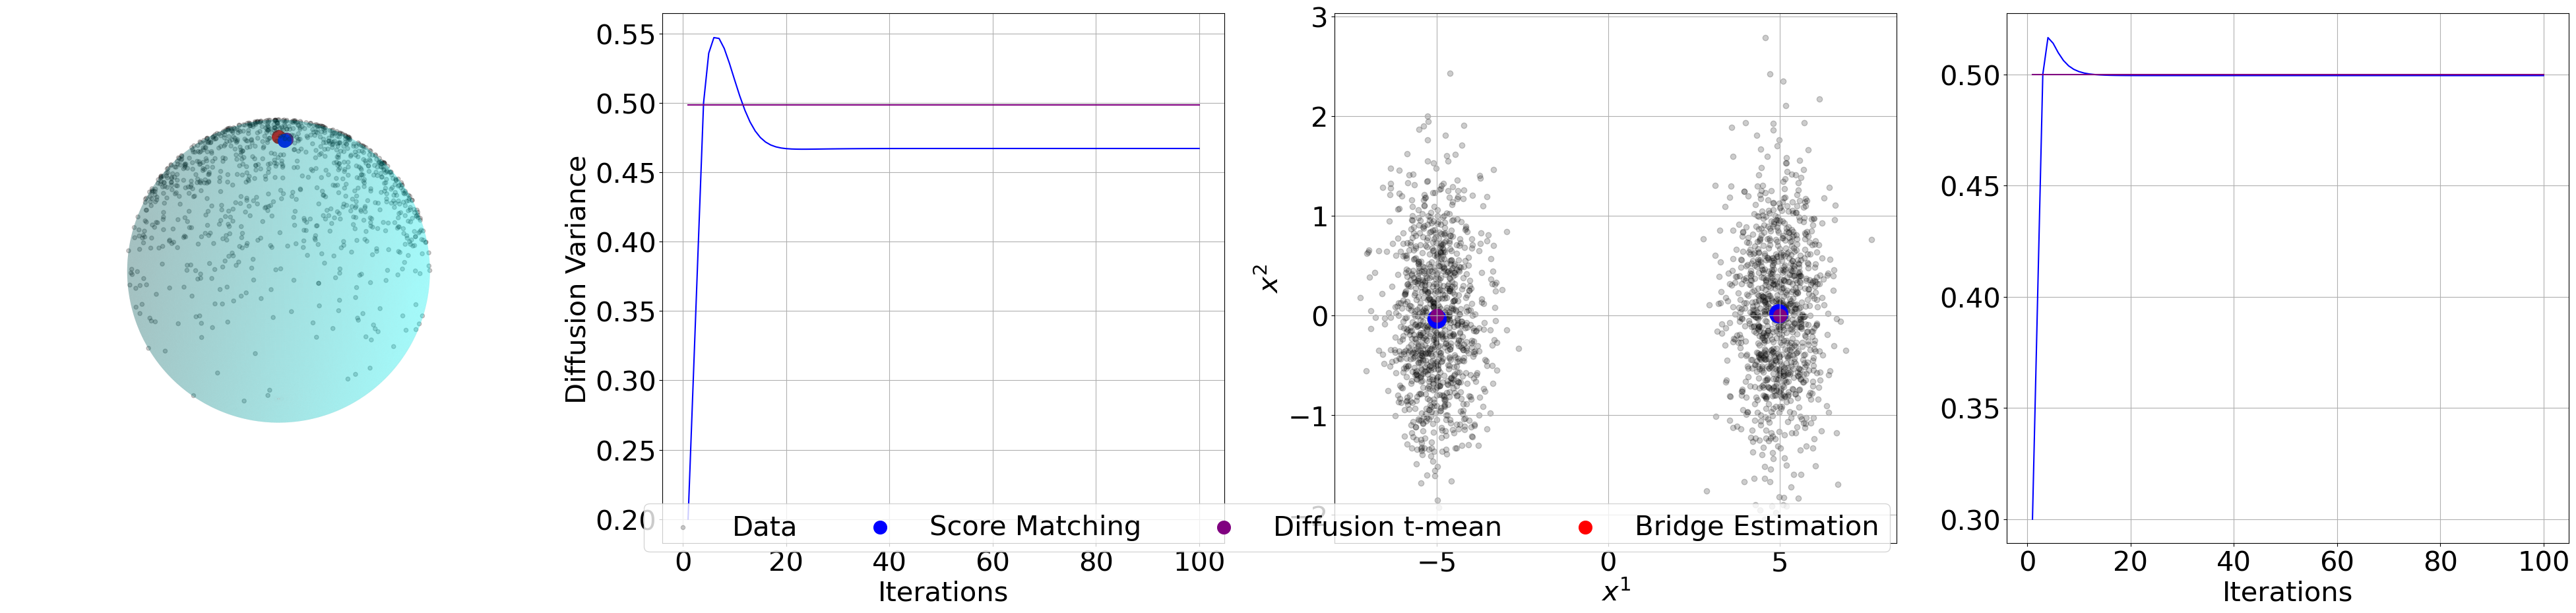

In [62]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(40,10))

#Landmarks
ax = fig.add_subplot(143)
obs = X_landmarks[0].reshape(1000,2,2)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
for i in range(len(obs)):
    plt.scatter(obs[i][0,0], obs[i][0,1], color='black', alpha=0.2)
    plt.scatter(obs[i][1,0], obs[i][1,1], color='black', alpha=0.2)
plt.scatter(mulandmarks_sm[0][-1].reshape(2,2)[0,0], mulandmarks_sm[0][-1].reshape(2,2)[0,1], color='blue', s=400)
plt.scatter(mulandmarks_sm[0][-1].reshape(2,2)[1,0], mulandmarks_sm[0][-1].reshape(2,2)[1,1], color='blue', s=400)
plt.scatter(x0[0].reshape(2,2)[0,0], x0[0].reshape(2,2)[0,1], color='purple', s=200)
plt.scatter(x0[0].reshape(2,2)[1,0], x0[0].reshape(2,2)[1,1], color='purple', s=200)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(144)
ax.plot(jnp.arange(1,len(Tlandmarks_sm)+1, 1), Tlandmarks_sm, color='blue')
ax.plot(jnp.arange(1,len(Tlandmarks_sm)+1, 1), 0.5*jnp.ones(len(Tlandmarks_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(X_sphere[1][:,0], X_sphere[1][:,1], X_sphere[1][:,2], color='black', alpha=0.2, label='Data')
ax.scatter(musphere_sm[1][-1,0], musphere_sm[1][-1,1], musphere_sm[1][-1,2], color='blue', label='Score Matching', alpha=1.0, s=200)
ax.scatter(musphere_opt[1][-1,0], musphere_opt[1][-1,1], musphere_opt[1][-1,2], color='purple', label='Diffusion t-mean', s=200)
ax.scatter(musphere_bridghechart[-1,0], musphere_bridghechart[1,1], musphere_bridghechart[2,2], color='red', label='Bridge Estimation', s=200)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(142)
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_sm, color='blue')
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_opt[-1]*jnp.ones(len(Tsphere_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.1), ncol=5)

plt.show()

fig.savefig('Figures/synthetic_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Conceptual Plot

### $\mathbb{S}^{2}$

In [63]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [64]:
file_path = 'scores/S2/'+ loss_type + '/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log_s2(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_s2(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log_s2(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [65]:
N_sim = 5
M = nSphere(N=2)
Brownian_coords(M)

(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

_dts = dts(T=1.0, n_steps=1000)
dW = dWs(N_sim*M.dim,_dts).reshape(-1,N_sim,M.dim)
(ts,xss,chartss,*_) = product(x0s,
                              _dts,dW,jnp.repeat(1.,N_sim))
chartss = vmap(lambda x,y: vmap(lambda x,chart: M.F((x,chart)))(x,y))(xss, chartss)

t = ts[jnp.arange(200,len(ts)+200, 200)]
xs = xss[jnp.arange(200,len(xss)+200, 200)]
chart = chartss[jnp.arange(200,len(chartss)+200, 200)]

using M.Exp for Logarithm


In [66]:
N_sim = 5
M = nSphere(N=2)
Brownian_coords(M)

(product, sde_product, chart_update_product) = product_sde(M, 
                                                           M.sde_Brownian_coords, 
                                                           M.chart_update_Brownian_coords)

x0 = M.coords([0.]*2)
x0s = tile(x0, N_sim)

using M.Exp for Logarithm


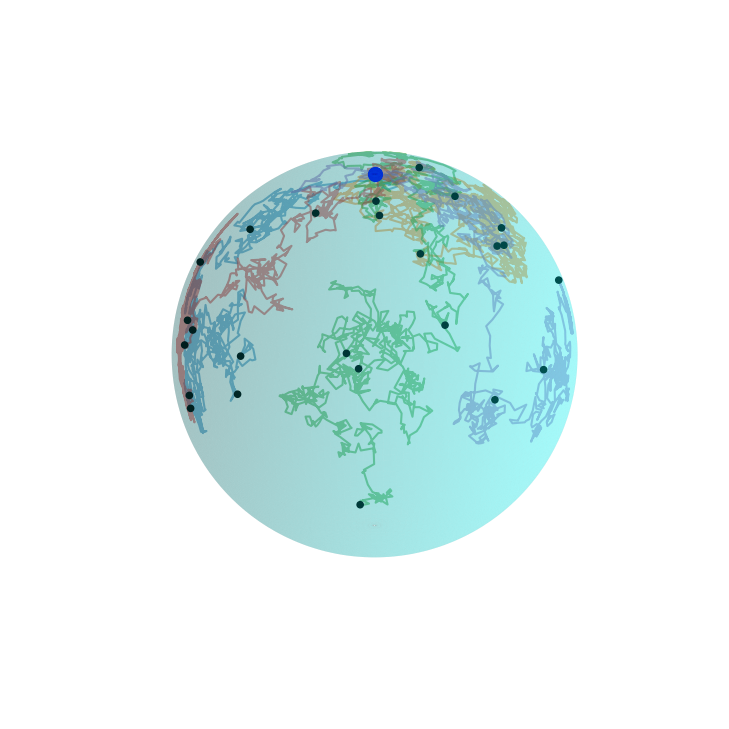

In [67]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_samples.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

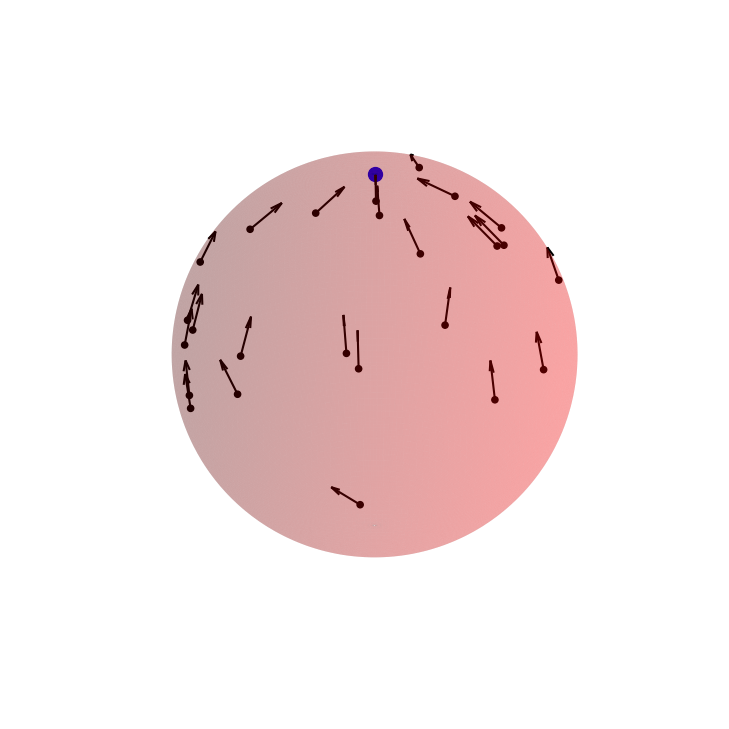

In [68]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

TM_grad_log = vmap(lambda x,chart,t: vmap(lambda x,y: M.grady_log_hk(x0,(x,y),t)[1])(x,chart))(xs,chart,t)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='red', alpha=0.2)
ax.scatter(chart[:,:,0], chart[:,:,1], chart[:,:,2], color='black', alpha=1.0)
ax.scatter(x0[1][0], x0[1][1], x0[1][2], color='blue', alpha=1.0, s=100)
ax.quiver(chart[:,:,0], chart[:,:,1], chart[:,:,2], 
          TM_grad_log[:,:,0], TM_grad_log[:,:,1], TM_grad_log[:,:,2], color='black', length=0.2, normalize=True)
#for i in range(N_sim):
#    ax.plot3D(chartss[:,i,0], chartss[:,i,1], chartss[:,i,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_gradients.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Plot Fréchet Mean

### $\mathbb{S}^{2}$

In [69]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [70]:
file_path = 'scores/S2/T/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [71]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [72]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

In [73]:
musm_s2, __ = S2.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

In [74]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(S2)

mufrechet_s2,loss,iterations,vs = S2.Frechet_mean(zip(X_obs[0], X_obs[1]),S2_x0)

Step 0 | T: 0.000000e+00 | T: 1.461105e+00
Step 10 | T: 2.509444e+00 | T: 2.730857e-01
Step 20 | T: 1.510581e+00 | T: 8.265243e-02
Step 30 | T: 1.171372e+00 | T: 5.634799e-02
Step 40 | T: 1.657797e+00 | T: 7.075077e-02
Step 50 | T: 1.405652e+00 | T: 2.582067e-02
Step 60 | T: 1.414604e+00 | T: 1.952962e-02
Step 70 | T: 1.395871e+00 | T: 4.457930e-03
Step 80 | T: 1.371018e+00 | T: 2.480170e-03
Step 90 | T: 1.403125e+00 | T: 7.007048e-04
Step 100 | T: 1.376484e+00 | T: 5.016936e-04
Step 110 | T: 1.381537e+00 | T: 5.096235e-04
Step 120 | T: 1.376408e+00 | T: 1.102507e-04
Step 130 | T: 1.372069e+00 | T: 1.501501e-04
Step 140 | T: 1.380178e+00 | T: 6.219289e-05
Step 150 | T: 1.375915e+00 | T: 4.266473e-05
Step 160 | T: 1.375755e+00 | T: 4.636609e-05
Step 170 | T: 1.374459e+00 | T: 5.363500e-06
Step 180 | T: 1.374325e+00 | T: 3.135944e-05
Step 190 | T: 1.375633e+00 | T: 6.463738e-06
Step 199 | T: 1.375476e+00 | T: 5.071239e-06 


### Torus

In [75]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [76]:
file_path = 'scores/Torus/T/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

In [77]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [78]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

In [79]:
mu_sm, __ = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

In [80]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(M)

mu_frechet,loss,iterations,vs = M.Frechet_mean(zip(X_obs[0], X_obs[1]),x0)

Step 0 | T: 0.000000e+00 | T: 8.369826e+00
Step 10 | T: 1.258283e+00 | T: 2.138886e+00
Step 20 | T: 1.167032e+00 | T: 2.416724e-01
Step 30 | T: 1.123042e+00 | T: 1.919807e-01
Step 40 | T: 9.799383e-01 | T: 2.004060e-01
Step 50 | T: 9.910663e-01 | T: 5.876143e-02
Step 60 | T: 1.000769e+00 | T: 6.419628e-02
Step 70 | T: 9.988730e-01 | T: 3.578848e-02
Step 80 | T: 9.744833e-01 | T: 3.145772e-02
Step 90 | T: 9.896396e-01 | T: 2.188000e-02
Step 100 | T: 9.936963e-01 | T: 1.557699e-02
Step 110 | T: 9.887246e-01 | T: 1.588880e-02
Step 120 | T: 9.818046e-01 | T: 6.365098e-03
Step 130 | T: 9.800748e-01 | T: 1.064173e-02
Step 140 | T: 9.865332e-01 | T: 2.043733e-03
Step 150 | T: 9.858813e-01 | T: 5.701423e-03
Step 160 | T: 9.832497e-01 | T: 1.695973e-03
Step 170 | T: 9.810843e-01 | T: 2.588808e-03
Step 180 | T: 9.829767e-01 | T: 1.371845e-03
Step 190 | T: 9.842321e-01 | T: 1.038445e-03
Step 199 | T: 9.838590e-01 | T: 1.096530e-03 


In [81]:
Xobs_torus = vmap(lambda x1,x2: M.F((x1,x2)))(X_obs[0], X_obs[1])
musm_torus = vmap(lambda x1,x2: M.F((x1,x2)))(mu_sm[0], mu_sm[1])
mufrechet_torus = M.F(mu_frechet)

### Cylinder

In [82]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [83]:
file_path = 'scores/Cylinder/T/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

In [84]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [85]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

In [86]:
mu_sm, __ = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.01]), 
                                     step_size=1.0, max_iter=100)

In [87]:
from jaxgeometry.statistics import Frechet_mean
Frechet_mean(M)

mu_frechet,loss,iterations,vs = M.Frechet_mean(zip(X_obs[0], X_obs[1]),x0)

Step 0 | T: 0.000000e+00 | T: 2.101420e+01
Step 10 | T: 9.021190e-01 | T: 8.629092e+00
Step 20 | T: 1.285974e+00 | T: 3.185791e+00
Step 30 | T: 1.125498e+00 | T: 5.821892e-01
Step 40 | T: 1.011828e+00 | T: 2.435212e-01
Step 50 | T: 1.016566e+00 | T: 1.088962e-01
Step 60 | T: 1.030019e+00 | T: 9.044576e-02
Step 70 | T: 1.033641e+00 | T: 6.554155e-02
Step 80 | T: 1.015054e+00 | T: 5.635281e-02
Step 90 | T: 1.032660e+00 | T: 3.189034e-02
Step 100 | T: 1.020949e+00 | T: 3.693931e-02
Step 110 | T: 1.021222e+00 | T: 2.310714e-02
Step 120 | T: 1.014831e+00 | T: 1.967280e-02
Step 130 | T: 1.013408e+00 | T: 1.479642e-02
Step 140 | T: 1.018988e+00 | T: 8.725167e-03
Step 150 | T: 1.013577e+00 | T: 8.862250e-03
Step 160 | T: 1.012260e+00 | T: 4.944273e-03
Step 170 | T: 1.011208e+00 | T: 4.744217e-03
Step 180 | T: 1.013663e+00 | T: 2.415291e-03
Step 190 | T: 1.012889e+00 | T: 2.282438e-03
Step 199 | T: 1.012012e+00 | T: 1.601880e-03 


In [88]:
Xobs_cylinder = vmap(lambda x1,x2: M.F((x1,x2)))(X_obs[0], X_obs[1])
musm_cylinder = vmap(lambda x1,x2: M.F((x1,x2)))(mu_sm[0], mu_sm[1])
mufrechet_cylinder = M.F(mu_frechet)

### Plot Fréchet Mean

using M.Exp for Logarithm
using M.Exp for Logarithm


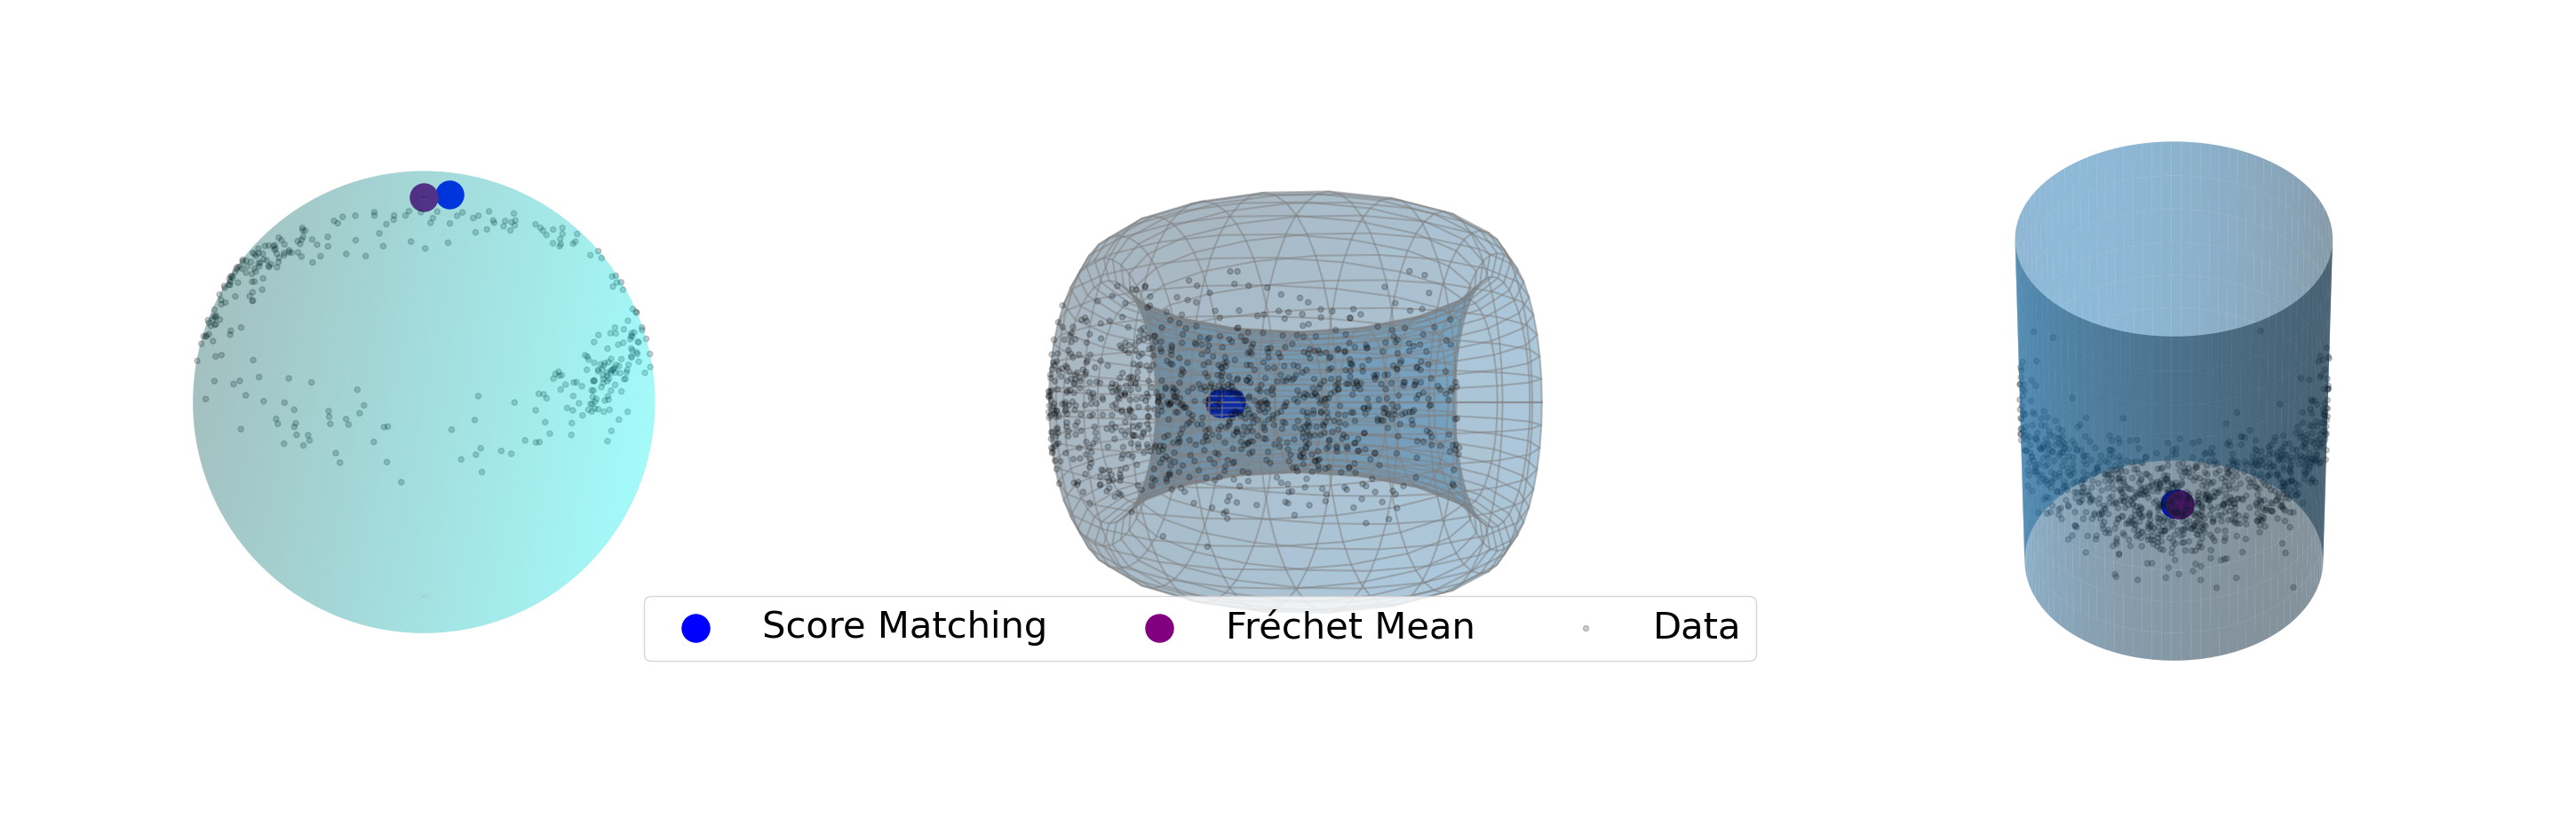

In [89]:
import numpy as np

plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(30,10))

#Landmarks
ax = fig.add_subplot(131, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(musm_s2[1][-1,0], musm_s2[1][-1,1], musm_s2[1][-1,2], color='blue', alpha=1.0, s=500, label='Score Matching')
ax.scatter(mufrechet_s2[1][0], mufrechet_s2[1][1], mufrechet_s2[1][2], color='purple', alpha=1.0, s=500, label='Fréchet Mean')
ax.scatter(Xobs_s2[1][:,0], Xobs_s2[1][:,1], Xobs_s2[1][:,2], color='black', alpha=0.2, label='Data')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

# Creating the theta and phi values.
M = Torus()
u, v = np.mgrid[-np.pi:np.pi:40j, -np.pi:np.pi:20j]
x = np.zeros(u.shape)
y = np.zeros(u.shape)
z = np.zeros(u.shape)
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        w = M.F(M.coords(jnp.array([u[i,j],v[i,j]])))
        x[i,j] = w[0]; y[i,j] = w[1]; z[i,j] = w[2]
#rot_mat = lambda v: jnp.array([[1.0, 0.0, 0.0],
#                     [0.0, jnp.cos(v), -jnp.sin(v)],
#                    [0.0, jnp.sin(v), -jnp.cos(v)]])
#X_circle = jnp.vstack((X_circle[0].reshape(1,-1),
#                       jnp.array([-X_circle[0][0], -X_circle[0][1], X_circle[0][2]]).reshape(1,-1))) #delete this

#X_circle = jnp.vstack((jnp.array([1.0, 0.0, 0.0]).reshape(1,-1),
#                      jnp.array([0.0, 1.0, 0.0]).reshape(1,-1)))
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(Xobs_torus[:,0], Xobs_torus[:,1], Xobs_torus[:,2], alpha=0.2, color='black')
ax.plot_wireframe(x, y, z, color='gray', alpha=0.5)
ax.scatter(musm_torus[:,0], musm_torus[:,1], musm_torus[:,2], color='blue', s=500)
ax.scatter(mufrechet_torus[0], mufrechet_torus[1], mufrechet_torus[2], color='purple', s=500)
ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.view_init(0, 20)

ax = fig.add_subplot(133, projection='3d')
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
#https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z, N_points=100):
    z = jnp.linspace(-height_z, height_z, N_points)
    theta = jnp.linspace(0, 2*jnp.pi, N_points)
    theta_grid, z_grid= jnp.meshgrid(theta, z)
    x_grid = radius*jnp.cos(theta_grid) + center_x
    y_grid = radius*jnp.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
Xc,Yc,Zc = data_for_cylinder_along_z(0.0,0.0,1.0,4.0)
ax.plot_surface(Xc, Yc, Zc, cstride=1, alpha=0.5)
ax.scatter(Xobs_cylinder[:,0], Xobs_cylinder[:,1], Xobs_cylinder[:,2], alpha=0.2, color='black')
ax.scatter(musm_cylinder[:,0], musm_cylinder[:,1], musm_cylinder[:,2], s=500, color='blue')
ax.scatter(mufrechet_cylinder[0], mufrechet_cylinder[1], mufrechet_cylinder[2], s=500, color='purple')
ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
ax.view_init(-140, 270)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.2), ncol=5)

plt.show()

fig.savefig('Figures/frechet_plot.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


## Plot Diffusion Mean

## Landmarks

In [90]:
N_sample = 20
N_half = N_sample // 2

In [91]:
data = pd.read_csv('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [92]:
with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [93]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    landmark_data.append(jnp.vstack((data1, data2)).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [94]:
M = Landmarks(N=N_sample,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

using M.Exp for Logarithm


In [95]:
file_path = 'scores/Landmarks'+str(N_sample)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N_sample<10:
    layers = [50,100,100,50]
elif 2*N_sample<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [96]:
X_obs = (landmark_data, jnp.zeros(len(landmark_data)))
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mulandmark_sm, Tlandmark_sm, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                             step_size=0.01, max_iter=1000)

## SPDN

In [97]:
N = 10

In [98]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [99]:
file_path = 'scores/SPDN'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

In [100]:
spdn_data = vmap(lambda x: jnp.eye(10)*x)(jnp.linspace(5,15,100))
X_obs = vmap(lambda x: get_coords(M, x.reshape(-1)))(spdn_data)

In [101]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
muspdn_sm, Tspdn_sm, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                             step_size=0.1, max_iter=100)

### $\mathbb{S}^{2}$

In [102]:
N = 2
M = nSphere(N=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [103]:
file_path = 'scores/S'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

In [104]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
Xsphere_obs = vmap(lambda chart: get_coords(S2, chart))(charts)


In [105]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [106]:
musphere_sm, Tsphere_sm, _, _ = M.sm_dmxt(Xsphere_obs, (Xsphere_obs[0][0], Xsphere_obs[1][0]), jnp.array([0.2]), 
                                         step_size=0.1, max_iter=100)

In [107]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
musphere_opt, Tsphere_opt, _, _ = M.sm_dmxt(Xsphere_obs, (Xsphere_obs[0][0], Xsphere_obs[1][0]), jnp.array([0.1]))

## Plotting

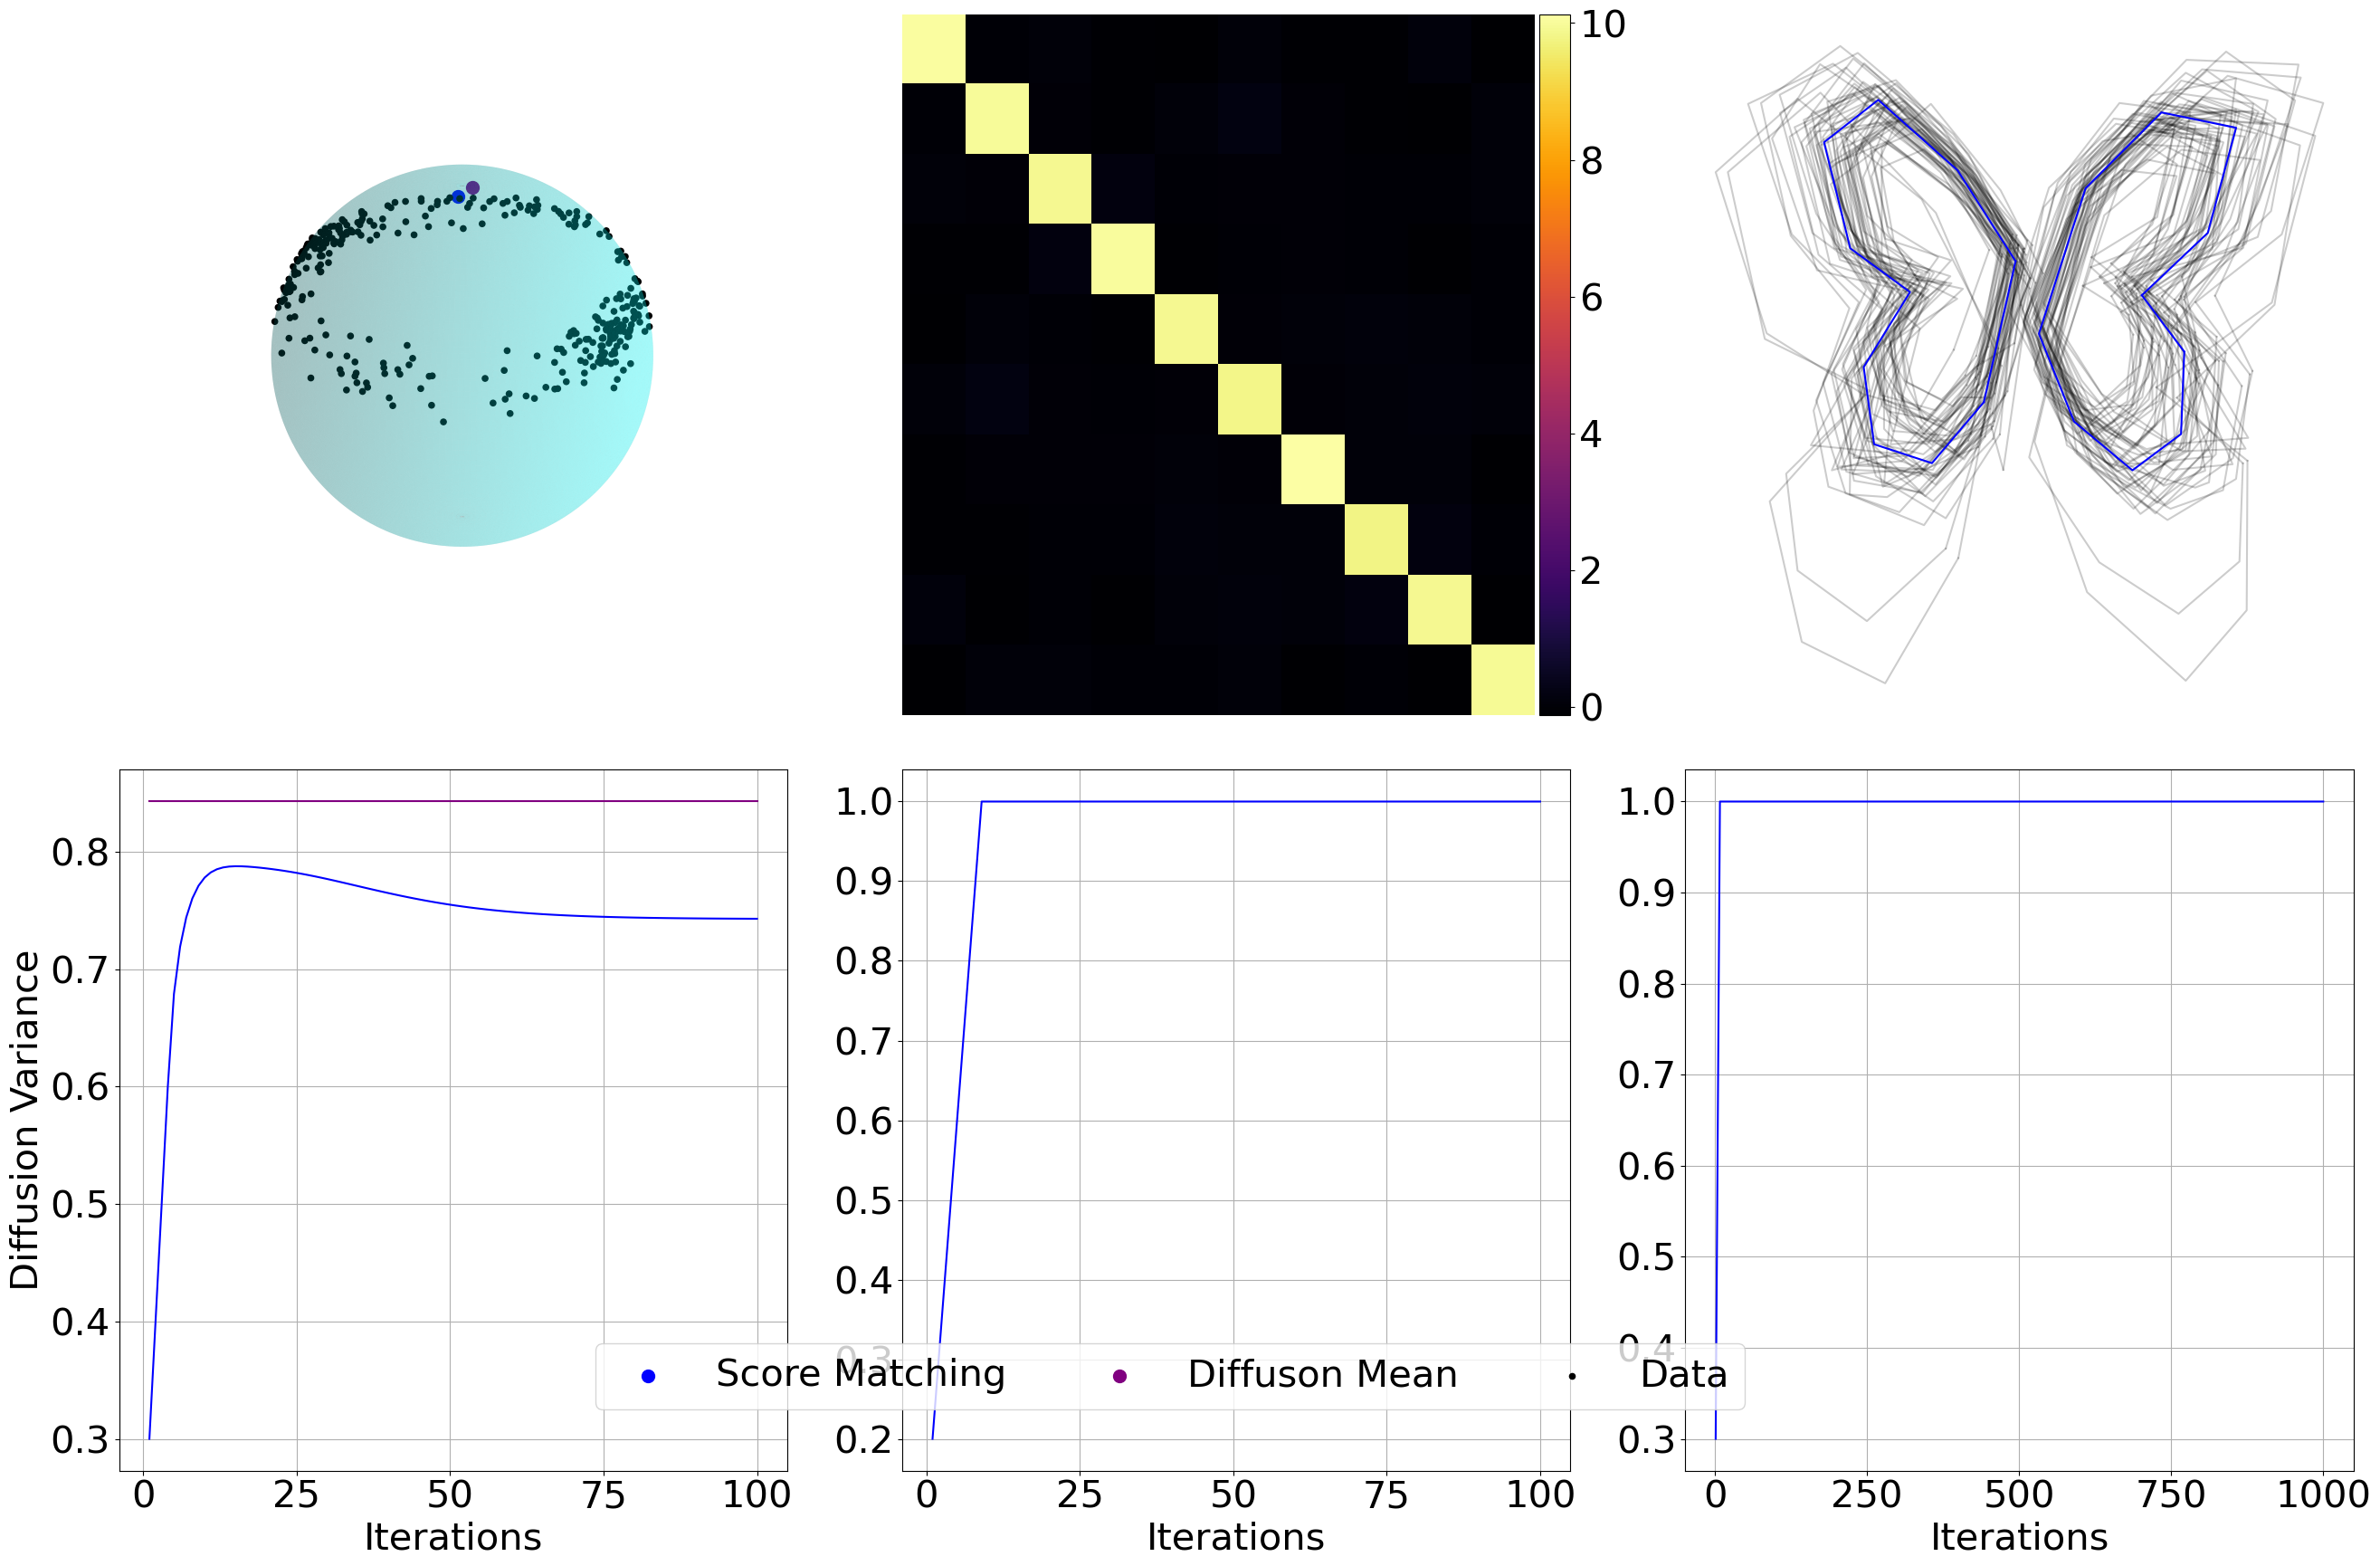

In [108]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(27,18))

#Landmarks
ax = fig.add_subplot(231, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(musphere_sm[1][-1,0], musphere_sm[1][-1,1], musphere_sm[1][-1,2], color='blue', alpha=1.0, s=100, label='Score Matching')
ax.scatter(musphere_opt[1][-1,0], musphere_opt[1][-1,1], musphere_sm[1][-1,2], color='purple', alpha=1.0, s=100, label='Diffuson Mean')
ax.scatter(Xsphere_obs[1][:,0], Xsphere_obs[1][:,1], Xsphere_obs[1][:,2], color='black', alpha=1.0, label='Data')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(232)
ax.imshow(muspdn_sm[1][-1].reshape(10,10), cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(muspdn_sm[1][-1].reshape(10,10))
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)

ax = fig.add_subplot(233)
mu = mulandmark_sm[0][-1].reshape(-1,2)
for wing in landmark_data:
    wing = wing.reshape(-1,2)
    ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color='black', alpha=0.2)
    ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color='black', alpha=0.2)
    ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color='black', alpha=.2)
ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(234)
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_sm, color='blue')
ax.plot(jnp.arange(1,len(Tsphere_sm)+1, 1), Tsphere_opt[-1]*jnp.ones(len(Tsphere_sm)), color='purple')
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Diffusion Variance')
fig.tight_layout()

ax = fig.add_subplot(235)
ax.plot(jnp.arange(1,len(Tspdn_sm)+1, 1), Tspdn_sm, color='blue')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

ax = fig.add_subplot(236)
ax.plot(jnp.arange(1,len(Tlandmark_sm)+1, 1), Tlandmark_sm, color='blue')
ax.grid(True)
ax.set_xlabel('Iterations')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.1), ncol=5)

plt.show()

fig.savefig('Figures/diffusion_mean_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')


# Clustering

### $\mathbb{S}^{2}$

In [109]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [110]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [111]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [112]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [113]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=0.1):
    
    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

#def frechet_fun(X_obs, X_init, t=0.01):
    
#    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [114]:
from jaxgeometry.statistics.score_matching import kmeans

In [115]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [136]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [137]:
centroidssm_s2, centroidsm_idxs_s2 = RMK.centroids, RMK.centroid_idx

### $\mathbb{S}^{2}$

In [138]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [139]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [140]:
from scipy.io import loadmat

sphere_data = loadmat('../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [141]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [142]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

#def frechet_fun(X_obs, X_init, t=0.1):
    
#    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
#    return (mu[0][-1], mu[1][-1])

def frechet_fun(X_obs, X_init, t=0.01):
    
    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [143]:
from jaxgeometry.statistics.score_matching import kmeans

In [145]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [146]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [147]:
centroidseuc_s2, centroideuc_idxs_s2 = RMK.centroids, RMK.centroid_idx

## Landmarks

In [69]:
N_sample = 20
N_half = N_sample // 2

In [70]:
data = pd.read_csv('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [71]:
with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [72]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    landmark_data.append(jnp.vstack((data1, data2)).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [73]:
M = Landmarks(N=N_sample,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

using M.Exp for Logarithm


In [74]:
file_path = 'scores/Landmarks'+str(N_sample)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N_sample<10:
    layers = [50,100,100,50]
elif 2*N_sample<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [78]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [80]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=0.1):
    
    mu = M.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

#def frechet_fun(X_obs, X_init, t=0.01):
    
#    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [81]:
from jaxgeometry.statistics.score_matching import kmeans

In [82]:
frechet_fun((landmark_data, jnp.zeros(len(landmark_data))), (landmark_data[0], jnp.zeros(1)))

(Array([  963.8528 ,  -568.2925 ,   812.1709 ,  -357.8545 ,   604.0095 ,
         -194.82944,   461.60522,  -292.96057,   530.4612 ,  -538.5249 ,
          686.8884 ,  -639.812  ,   565.83203,  -813.2739 ,   592.57104,
         -991.92017,   744.37476, -1034.9146 ,   880.80664,  -893.9868 ,
         1296.4648 ,  -647.2068 ,  1468.2905 ,  -502.37988,  1542.5322 ,
         -259.30945,  1346.6631 ,  -223.8322 ,  1147.3628 ,  -399.5067 ,
         1025.127  ,  -735.6948 ,  1118.3237 ,  -938.69604,  1270.4551 ,
        -1051.4604 ,  1398.0557 ,  -967.88525,  1406.5942 ,  -777.7571 ],      dtype=float32),
 Array([0.], dtype=float32))

In [83]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [85]:
RMK.fit((landmark_data, jnp.zeros(len(landmark_data)))) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [86]:
centroidssm_landmark, centroidsm_idxs_landmark = RMK.centroids, RMK.centroid_idx

## Landmarks

In [98]:
N_sample = 20
N_half = N_sample // 2

In [99]:
data = pd.read_csv('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt')

In [100]:
with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [101]:
landmark_data = []
for i in range(0,len(all_data), 2):
    data1 = jnp.array([int(float(x)) for x in all_data[i].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    data2 = jnp.array([int(float(x)) for x in all_data[i+1].split()[2:]], dtype=jnp.float32)[::(100//N_sample)]
    landmark_data.append(jnp.vstack((data1, data2)).T.flatten())
    
landmark_data = jnp.vstack(landmark_data)

In [102]:
M = Landmarks(N=N_sample,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

using M.Exp for Logarithm


In [103]:
file_path = 'scores/Landmarks'+str(N_sample)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N_sample<10:
    layers = [50,100,100,50]
elif 2*N_sample<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

In [112]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[0]-y[0])

In [118]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

#def frechet_fun(X_obs, X_init, t=0.1):
    
#    mu = M.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
#    return (mu[0][-1], mu[1][-1])

def frechet_fun(X_obs, X_init, t=0.01):
    
    return (jnp.mean(X_obs[0], axis=0), jnp.zeros(1))
    

In [119]:
from jaxgeometry.statistics.score_matching import kmeans

In [121]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=4, max_iter = 10)

In [122]:
RMK.fit((landmark_data, jnp.zeros(len(landmark_data)))) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [123]:
centroidseuc_landmark, centroidseuc_idxs_landmark = RMK.centroids, RMK.centroid_idx

### Plotting

In [ ]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(30,10))
color = ['magenta', 'red', 'green', 'orange']

#Landmarks
ax = fig.add_subplot(141, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(centroidseuc_s2[1][:,0], centroidseuc_s2[1][:,1], centroidseuc_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
for i in range(len(centroideuc_idxs_s2)):
    ax.scatter(X_obs[1][centroideuc_idxs_s2[i],0], 
               X_obs[1][centroideuc_idxs_s2[i],1], 
               X_obs[1][centroideuc_idxs_s2[i],2], alpha=0.2, s=100, color=color[i], label='Cluser ' + str(i+1))
#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()
fig.tight_layout()

ax = fig.add_subplot(142, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300)
for i in range(len(centroideuc_idxs_s2)):
    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
               X_obs[1][centroidsm_idxs_s2[i],1], 
               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.2, s=100, color=color[i])
#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

ax = fig.add_subplot(143)
for i in range(len(centroidseuc_idxs_landmark)):
    for wing in landmark_data[centroidseuc_idxs_landmark[i]]:
        wing = wing.reshape(-1,2)
        ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color=color[i], alpha=0.2)
        ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color=color[i], alpha=.2)
for mu in centroidseuc_landmark[0]:
    mu = mu.reshape(-1,2)
    ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
    ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
    ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
    ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

ax = fig.add_subplot(144)
for i in range(len(centroidsm_idxs_landmark)):
    for wing in landmark_data[centroidsm_idxs_landmark[i]]:
        wing = wing.reshape(-1,2)
        ax.plot(wing[:,0][:N_half:1],wing[:,1][:N_half:1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[:,0][0],wing[:,0][N_half-1]]), jnp.array([wing[:,1][0], wing[:,1][N_half-1]]), '-', color=color[i], alpha=0.2)
        ax.plot(wing[:,0][N_half::1],wing[:,1][N_half::1], '-', color=color[i], alpha=0.2)
        ax.plot(jnp.array([wing[-1,0], wing[N_half,0]]), jnp.array([wing[-1,1], wing[N_half,1]]), '-', color=color[i], alpha=.2)
for mu in centroidssm_landmark[0]:
    mu = mu.reshape(-1,2)
    ax.plot(mu[:,0][:N_half:1],mu[:,1][:N_half:1], '-', color='blue')
    ax.plot(jnp.array([mu[:,0][0],mu[:,0][N_half-1]]), jnp.array([mu[:,1][0], mu[:,1][N_half-1]]), '-', color='blue')
    ax.plot(mu[:,0][N_half::1],mu[:,1][N_half::1], '-', color='blue')
    ax.plot(jnp.array([mu[-1,0], mu[N_half,0]]), jnp.array([mu[-1,1], mu[N_half,1]]), '-', color='blue')
ax.grid(True)
ax.set_axis_off()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.2,0.1), ncol=5)

plt.show()

fig.savefig('Figures/kmeans_data.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')